This cell imports all necessary Python libraries for web scraping, data processing, geocoding, and visualization. Libraries include `requests` for HTTP requests, `BeautifulSoup` for HTML parsing, `pandas` for data manipulation, `re` for regular expressions, `matplotlib` and `seaborn` for plotting, `cartopy` for geographic visualization, `geopy` for geocoding, `folium` for interactive maps, and `numpy` for numerical operations.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
from folium.plugins import Fullscreen, MeasureControl
import numpy as np

Initializes the `Nominatim` geolocator from the `geopy` library with a custom user agent (`flight_route_analyzer`). This will be used to retrieve latitude and longitude coordinates for cities.

In [ ]:
# Initialize geolocator for country detection(logtuide and lateduide)
geolocator = Nominatim(user_agent="flight_route_analyzer")

Fetches the HTML content of the Wikipedia page listing the busiest passenger flight routes using the `requests` library. The content is then parsed with `BeautifulSoup` for further processing.

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_busiest_passenger_flight_routes"

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

Creates an empty list (`flights`) to store the extracted flight route data, including details like origin, destination, passenger count, and coordinates.

In [4]:
flights = []

Defines the `clean_passengers` function, which processes raw passenger count text by removing references (e.g., `[1]`) and commas, converting the cleaned text to an integer. Returns `None` if conversion fails.

In [5]:
def clean_passengers(passenger_text):
    cleaned = re.sub(r'\[\d+\]', '', passenger_text).replace(',', '').strip()
    try:
        return int(cleaned)
    except ValueError:
        return None

Defines the `get_table_year` function to extract the year associated with a table. It searches for a year in the table's caption or the preceding header (`h2` or `h3`). Returns `None` if no year is found.

In [6]:
def get_table_year(table):
    caption = table.find_previous(["h2", "h3"])
    if caption:
        match = re.search(r'\b(20\d{2})\b', caption.text)
        if match:
            return match.group(1)
    caption = table.find("caption")
    if caption:
        match = re.search(r'\b(20\d{2})\b', caption.text)
        if match:
            return match.group(1)
    return None

Locates all tables with the `wikitable` class on the Wikipedia page using `BeautifulSoup`. These tables contain the flight route data to be scraped.

In [7]:
tables = soup.find_all("table", class_="wikitable")

Defines the `get_location` function to retrieve latitude and longitude for a given city using the `Nominatim` geolocator. Then, processes each table to extract flight route data, including origin, destination, passenger count, route type (Domestic/International), and coordinates. Cleans city names and appends valid data to the `flights` list.

In [8]:
# get lateduide and logtuide
def get_location(city):
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            address = location.raw.get('address', {})
            return location.latitude, location.longitude
        return  None, None
    except GeocoderTimedOut:
        return  None, None

# Process each table
for table in tables:
    # Determine route type based on table context
    caption = table.find_previous(["h2", "h3"])
    route_type = "Unknown"  # Default
    if caption and "Domestic" in caption.text:
        route_type = "Domestic"
    elif caption and "International" in caption.text:
        route_type = "International"    
    
    table_year = get_table_year(table)
    
    # Get headers to identify column indices
    headers = table.find("tr").find_all(["th", "td"])
    col_indices = {
        "from": None,
        "to": None,
        "passengers": None,
        "year": None
    }
    
    # Identify relevant columns
    for i, header in enumerate(headers):
        header_text = header.text.strip().lower()
        if "airport" in header_text or "city" in header_text:
            if col_indices["from"] is None:
                col_indices["from"] = i
            else:
                col_indices["to"] = i
        elif "passenger" in header_text:
            col_indices["passengers"] = i
        elif "year" in header_text:
            col_indices["year"] = i
    
    # Get all rows in the table body
    rows = table.find("tbody").find_all("tr")[1:]  # Skip header row
    
    for row in rows:
        cols = row.find_all("td")
        if len(cols) >= 3:  # Ensure enough columns
            # Extract data
            from_city = cols[col_indices["from"]].text.strip() if col_indices["from"] is not None else None
            to_city = cols[col_indices["to"]].text.strip() if col_indices["to"] is not None else None
            passengers = clean_passengers(cols[col_indices["passengers"]].text.strip()) if col_indices["passengers"] is not None else None
            year = cols[col_indices["year"]].text.strip() if col_indices["year"] is not None else table_year
            
            # Skip rows with missing critical data
            if from_city and to_city and passengers and year:
                # Clean city names (remove airport codes, extra info, state codes)
                from_city = re.sub(r'\([^)]*\)|\b[A-Z]{3}\b|\b[A-Z]{2}\b', '', from_city).strip()
                to_city = re.sub(r'\([^)]*\)|\b[A-Z]{3}\b|\b[A-Z]{2}\b', '', to_city).strip()
                
                # Get coordinates
                from_lat, from_lon = get_location(from_city)
                to_lat, to_lon = get_location(to_city)
                
                # Only append if coordinates are available
                if from_lat and from_lon and to_lat and to_lon:
                    flights.append({
                        "From": from_city,
                        "To": to_city,
                        "Type": route_type,
                        "Year": year,
                        "Passengers": passengers,
                        "From_Lat": from_lat,
                        "From_Lon": from_lon,
                        "To_Lat": to_lat,
                        "To_Lon": to_lon
                    })

Converts the `flights` list into a `pandas` DataFrame for easier data manipulation and analysis. Displays the DataFrame to verify the scraped data.

In [9]:
df = pd.DataFrame(flights)
df

,From,To,Type,Year,Passengers,From_Lat,From_Lon,To_Lat,To_Lon
0,London,Dublin,Unknown,2011,5106040,51.489334,-0.144055,53.349379,-6.260559
1,Moscow,Saint Petersburg,Unknown,2011,5051518,55.625578,37.606392,59.960674,30.158655
2,London,Amsterdam,Unknown,2011,4920551,51.489334,-0.144055,52.373080,4.892453
3,London,New York,Unknown,2011,4869777,51.489334,-0.144055,40.712728,-74.006015
4,London,Dubai,Unknown,2011,3630407,51.489334,-0.144055,25.074282,55.188539
...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",Unknown,2014,2720000,33.748992,-84.390264,41.875562,-87.624421
96,"Chicago,","Minneapolis,",Unknown,2014,2720000,41.875562,-87.624421,44.977300,-93.265469
97,"Atlanta,","New York,",Unknown,2014,2600000,33.748992,-84.390264,40.712728,-74.006015
98,"Atlanta,","Orlando,",Unknown,2014,2620000,33.748992,-84.390264,28.542111,-81.379030


Creates a dictionary (`city_to_country`) mapping city names to their respective countries. Adds `From_Country` and `To_Country` columns to the DataFrame by mapping the `From` and `To` columns using this dictionary.

In [10]:
city_to_country = {
    "Bogotá": "Colombia",
    "Buenos Aires": "Argentina",
    "Buenos Aires - Aeroparque": "Argentina",
    "London": "United Kingdom",
    "Istanbul/Sabiha Gökçen": "Turkey",
    "Melbourne": "Australia",
    "Chicago": "United States",
    "Chicago,": "United States",
    "Istanbul/Havalimani": "Turkey",
    "Sydney": "Australia",
    "Brisbane": "Australia",
    "Perth": "Australia",
    "Atlanta": "United States",
    "Atlanta,": "United States",
    "Adelaide": "Australia",
    "Belo Horizonte": "Brazil",
    "Recife": "Brazil",
    "Brasília": "Brazil",
    "Porto Alegre": "Brazil",
    "Paris": "France",
    "Los Angeles": "United States",
    "Los Angeles,": "United States",
    "Gold Coast": "Australia",
    "Mendoza": "Argentina",
    "Salvador": "Brazil",
    "Moscow": "Russia",
    "Cartagena": "Colombia",
    "Medellín": "Colombia",
    "Antalya": "Turkey",
    "Rio de Janeiro-Santos Dumont": "Brazil",
    "Miami": "United States",
    "Miami,": "United States",
    "Dublin": "Ireland",
    "Saint Petersburg": "Russia",
    "Amsterdam": "Netherlands",
    "New York": "United States",
    "New York,": "United States",
    "Dubai": "United Arab Emirates",
    "Barcelona": "Spain",
    "Edinburgh": "United Kingdom",
    "Toulouse": "France",
    "Nice": "France",
    "Madrid": "Spain",
    "São Paulo-Congonhas": "Brazil",
    "São Paulo-Guarulhos": "Brazil",
    "Santiago de Chile": "Chile",
    "São Paulo": "Brazil",
    "Rio de Janeiro": "Brazil",
    "Lima": "Peru",
    "Rome": "Italy",
    "Córdoba": "Argentina",
    "Bariloche": "Argentina",
    "Iguazú": "Argentina",
    "Salta": "Argentina",
    "Neuquén": "Argentina",
    "Tucumán": "Argentina",
    "Ushuaia": "Argentina",
    "Comodoro Rivadavia": "Argentina",
    "El Calafate": "Argentina",
    "Hobart": "Australia",
    "Singapore": "Singapore",
    "Auckland": "New Zealand",
    "Hong Kong": "China (Hong Kong)",
    "Denpasar": "Indonesia",
    "Cali": "Colombia",
    "Barranquilla": "Colombia",
    "Santa Marta": "Colombia",
    "Archipelago of San Andrés, Providencia and San...": "Colombia",
    "San Andrés": "Colombia",  
    "Bucaramanga": "Colombia",
    "Pereira": "Colombia",
    "Montería": "Colombia",
    "Panama City": "Panama",
    "Mexico City": "Mexico",
    "Quito": "Ecuador",
    "Cancún": "Mexico",
    "Izmir": "Turkey",
    "Moscow/Vnukovo": "Russia",
    "Ankara": "Turkey",
    "Trabzon": "Turkey",
    "Tehran": "Iran",
    "Adana": "Turkey",
    "San Francisco,": "United States",
    "Minneapolis,": "United States",
    "Orlandome": "United States",
    "Orlando,": "United States",
    "Washington,": "United States"
}
df["From_Country"] = df["From"].map(city_to_country)
df["To_Country"] = df["To"].map(city_to_country)

Groups the DataFrame by `To_Country` and calculates the total passengers for each destination country. Displays the top 5 busiest destination countries based on passenger volume.

In [11]:
busiest_destination_countries = df.groupby("To_Country")["Passengers"].sum().sort_values(ascending=False).head(5)
busiest_destination_countries

To_Country
United States    37718216
Australia        32355860
Brazil           18417237
Turkey           15365557
Colombia         13588590
Name: Passengers, dtype: int64

Updates the `Type` column to classify routes as `Domestic` or `International` based on whether `From_Country` matches `To_Country`. This corrects any misclassifications from the initial table context.

In [12]:
df["Type"] = df.apply(
    lambda row: "Domestic" if row["From_Country"] == row["To_Country"] else "International",
    axis=1
)

Replaces occurrences of "Israel Occupation" with "Palestine" in the `From_Country` and `To_Country` columns of the DataFrame.

In [13]:
df["From_Country"] = df["From_Country"].replace({"Israel": "Palestine"})
df["To_Country"] = df["To_Country"].replace({"Israel": "Palestine"})

In [14]:
df

,From,To,Type,Year,Passengers,From_Lat,From_Lon,To_Lat,To_Lon,From_Country,To_Country
0,London,Dublin,International,2011,5106040,51.489334,-0.144055,53.349379,-6.260559,United Kingdom,Ireland
1,Moscow,Saint Petersburg,Domestic,2011,5051518,55.625578,37.606392,59.960674,30.158655,Russia,Russia
2,London,Amsterdam,International,2011,4920551,51.489334,-0.144055,52.373080,4.892453,United Kingdom,Netherlands
3,London,New York,International,2011,4869777,51.489334,-0.144055,40.712728,-74.006015,United Kingdom,United States
4,London,Dubai,International,2011,3630407,51.489334,-0.144055,25.074282,55.188539,United Kingdom,United Arab Emirates
...,...,...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",Domestic,2014,2720000,33.748992,-84.390264,41.875562,-87.624421,United States,United States
96,"Chicago,","Minneapolis,",Domestic,2014,2720000,41.875562,-87.624421,44.977300,-93.265469,United States,United States
97,"Atlanta,","New York,",Domestic,2014,2600000,33.748992,-84.390264,40.712728,-74.006015,United States,United States
98,"Atlanta,","Orlando,",Domestic,2014,2620000,33.748992,-84.390264,28.542111,-81.379030,United States,United States


### Visualize Top 5 Busiest Destination Countries
This cell creates a bar plot using `seaborn` to visualize the top 5 busiest destination countries by passenger volume. It defines a custom color palette and sets a consistent style with a light background and grid lines. The plot includes:
- A bar plot of passenger counts by country.
- Customized title, axis labels, and tick labels with specific fonts and colors.
- Data labels above each bar showing the exact passenger count.
- A tight layout to ensure proper spacing.
The plot is displayed using `matplotlib`.

C:\Users\Dell\AppData\Local\Temp\ipykernel_16776\4141505193.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


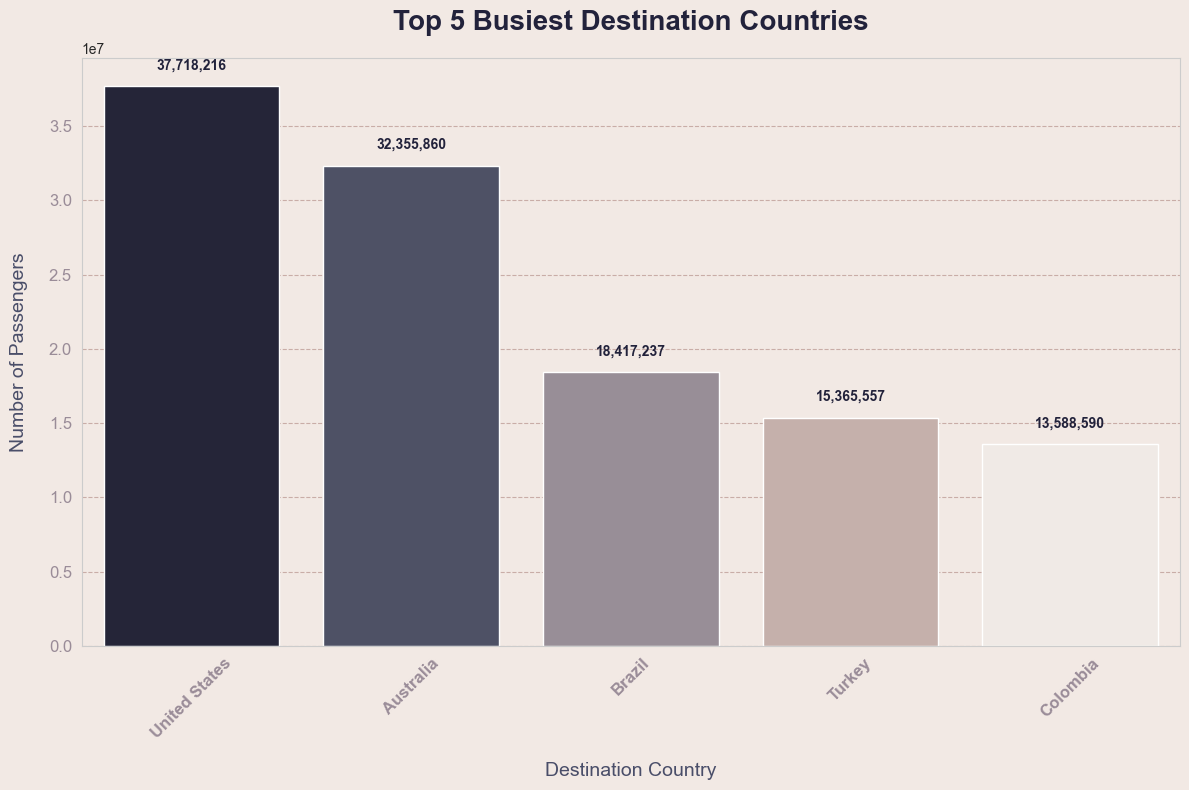

In [15]:
custom_palette = ['#22223b', '#4a4e69', '#9a8c98', '#c9ada7', '#f2e9e4']

sns.set_style("whitegrid", {
    "axes.facecolor": "#f2e9e4",    
    "figure.facecolor": "#f2e9e4",  
    "grid.color": "#c9ada7",        
    "grid.linestyle": "--"          
})
sns.set_palette(custom_palette)

plt.figure(figsize=(12, 8))  
barplot = sns.barplot(
    x=busiest_destination_countries.index, 
    y=busiest_destination_countries.values, 
    palette=custom_palette
)

plt.title('Top 5 Busiest Destination Countries', fontsize=20, color='#22223b', weight='bold', pad=20)
plt.xlabel('Destination Country', fontsize=14, color='#4a4e69', labelpad=15)
plt.ylabel('Number of Passengers', fontsize=14, color='#4a4e69', labelpad=15)

plt.xticks(rotation=45, fontsize=12, color='#9a8c98', weight='bold')
plt.yticks(fontsize=12, color='#9a8c98')

for index, value in enumerate(busiest_destination_countries.values):
    plt.text(
        index, value + 0.03 * max(busiest_destination_countries.values), 
        f"{value:,}",  
        ha='center', fontsize=10, color='#22223b', weight='bold'
    )

plt.tight_layout()
plt.show()

### Plot Top 5 Busiest Destination Countries
This cell generates a `seaborn` bar plot to display the top 5 destination countries by passenger volume. It uses a custom color palette and a styled grid layout with a light background. The plot features:
- Bars representing passenger counts per country.
- Customized title, axis labels, and tick styles.
- Passenger count labels above each bar.
- A tight layout for optimal spacing.
The plot is rendered using `matplotlib`.

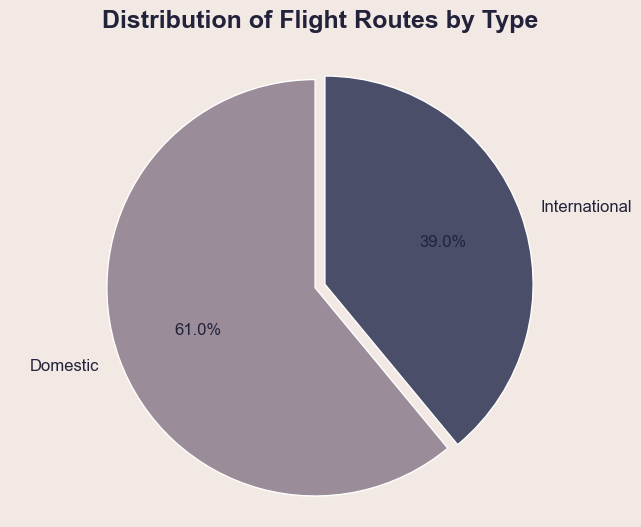

In [ ]:
type_counts = df["Type"].value_counts()

custom_colors = ['#9a8c98', '#4a4e69']  

plt.figure(figsize=(8, 6))  
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',     
    colors=custom_colors, 
    startangle=90,         
    explode=(0.05, 0),     
    textprops={'fontsize': 12, 'color': '#22223b'} 
)

plt.title(
    "Distribution of Flight Routes by Type",
    fontsize=18,
    color='#22223b',
    weight='bold',
    pad=20  
)
plt.axis('equal')
plt.show()

### Visualize Total Passengers Over Time
This cell creates a line plot using `seaborn` to show the total number of passengers across all flight routes by year. It:
- Groups the DataFrame by `Year` and sums the `Passengers` column.
- Plots the data with a line and markers for each year.
- Includes a title, labeled axes, and a grid for readability.
- Applies a tight layout for proper spacing.
The plot is displayed using `matplotlib`.

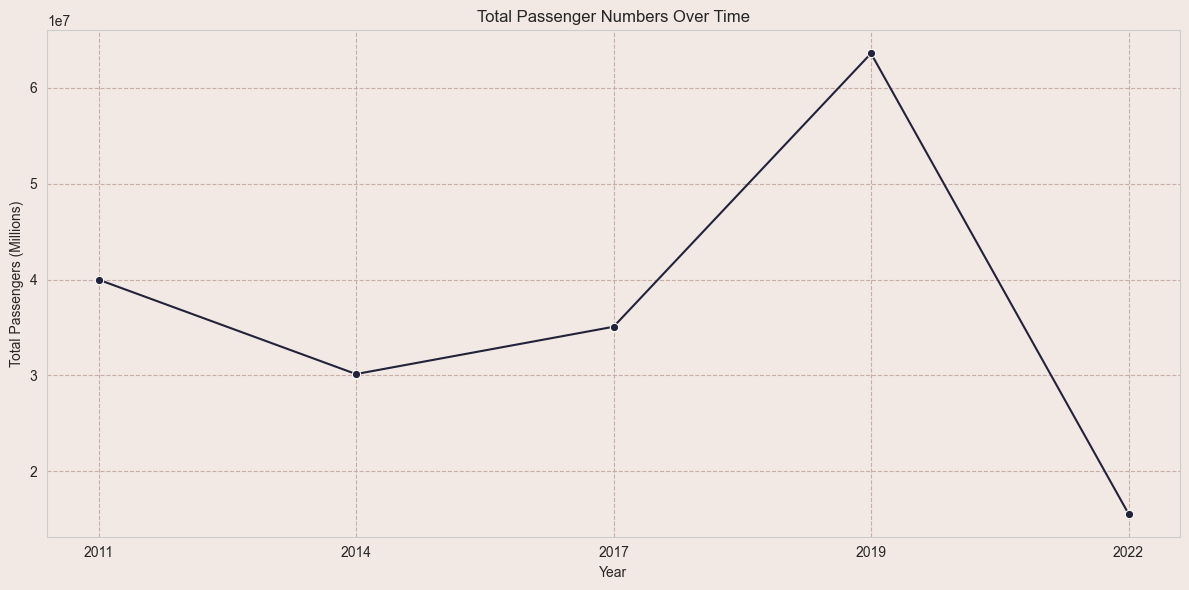

In [17]:
plt.figure(figsize=(12, 6))
passengers_by_year = df.groupby("Year")["Passengers"].sum().reset_index()
sns.lineplot(x="Year", y="Passengers", data=passengers_by_year, marker="o")
plt.title("Total Passenger Numbers Over Time")
plt.xlabel("Year")
plt.ylabel("Total Passengers (Millions)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualize Top 10 Busiest Flight Routes
This cell generates a horizontal bar plot using `seaborn` to display the top 10 busiest flight routes by total passenger numbers. It:
- Applies a custom style with a light background, grid lines, and a predefined color palette.
- Creates a `Route` column by combining `From` and `To` city names.
- Groups the DataFrame by `Route`, sums the `Passengers`, and selects the top 10 routes.
- Plots the routes with passenger counts, using customized title, axis labels, and tick styles.
- Ensures proper spacing with a tight layout.
The plot is rendered using `matplotlib`.

C:\Users\Dell\AppData\Local\Temp\ipykernel_16776\1770098779.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\Dell\AppData\Local\Temp\ipykernel_16776\1770098779.py:12: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  barplot = sns.barplot(


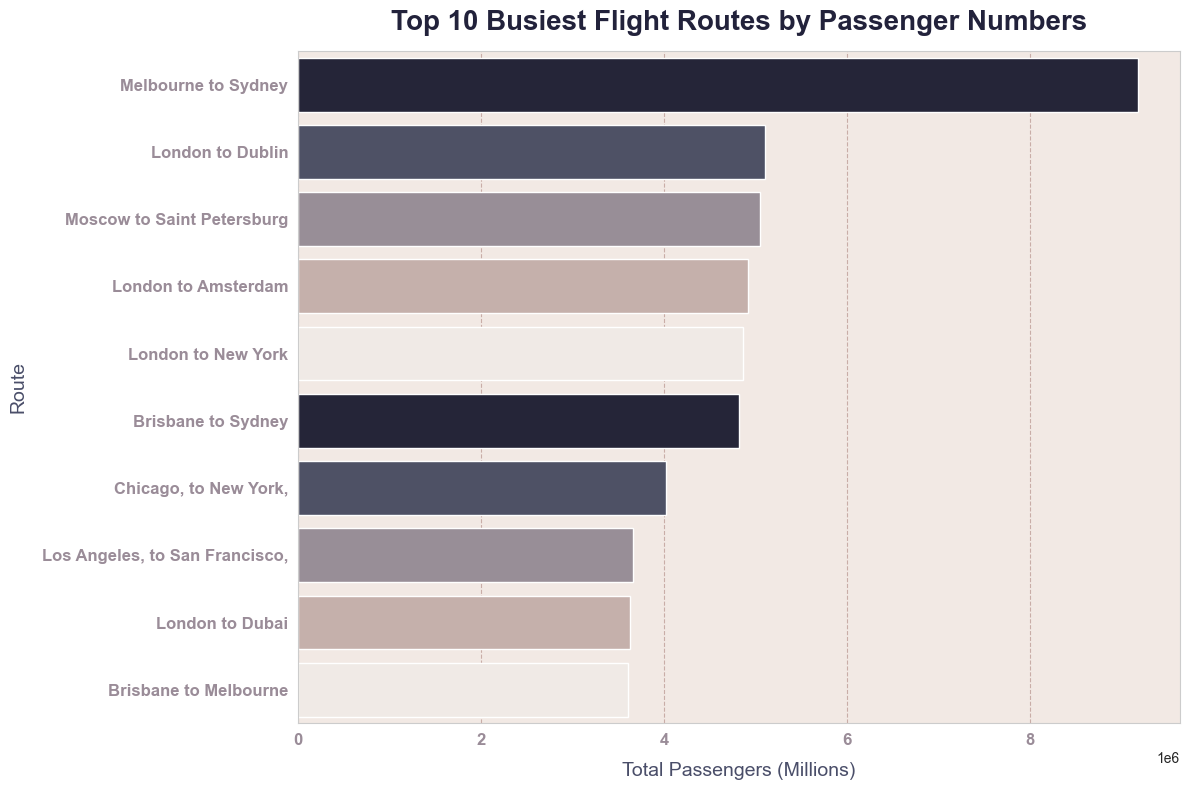

In [18]:
sns.set_style("whitegrid", {
    "axes.facecolor": "#f2e9e4",   
    "grid.color": "#c9ada7",       
    "grid.linestyle": "--"         
})
sns.set_palette(custom_palette)

df["Route"] = df["From"] + " to " + df["To"]
top_routes = df.groupby("Route")["Passengers"].sum().reset_index().sort_values("Passengers", ascending=False).head(10)

plt.figure(figsize=(12, 8))  
barplot = sns.barplot(
    x="Passengers", 
    y="Route", 
    data=top_routes, 
    palette=custom_palette  
)

plt.title(
    "Top 10 Busiest Flight Routes by Passenger Numbers", 
    fontsize=20, 
    color="#22223b", 
    weight="bold", 
    pad=15  
)
plt.xlabel("Total Passengers (Millions)", fontsize=14, color="#4a4e69", labelpad=10)
plt.ylabel("Route", fontsize=14, color="#4a4e69", labelpad=10)

plt.xticks(fontsize=12, color="#9a8c98", weight="bold")
plt.yticks(fontsize=12, color="#9a8c98", weight="bold")

plt.tight_layout()
plt.show()

### Visualize Top 5 Departure Countries by Route Type
This cell creates a grouped bar plot using `pandas` and `matplotlib` to show the top 5 departure countries by passenger volume, split by route type (Domestic/International). It:
- Groups the DataFrame by `From_Country` and `Type`, summing `Passengers` and pivoting to create a table with route types as columns.
- Calculates the total passengers per country, selects the top 5, and drops the total column.
- Plots the data with custom colors for Domestic and International routes.
- Customizes the title, axis labels, tick styles, and legend for clarity.
- Applies a tight layout for optimal spacing.
The plot is displayed using `matplotlib`.

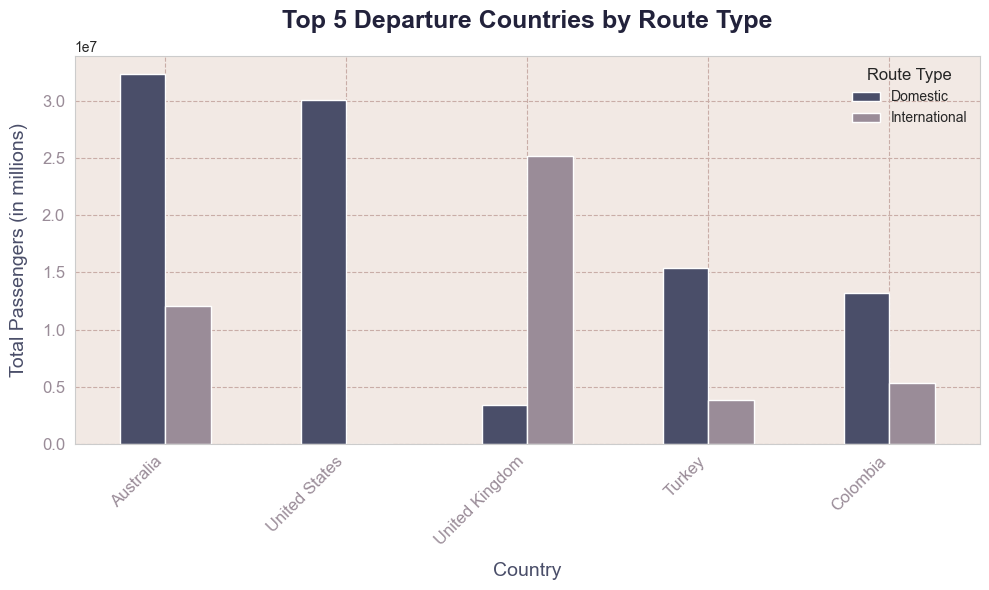

In [19]:
top_departure_countries = df.groupby(["From_Country", "Type"])["Passengers"].sum().unstack().fillna(0)
top_departure_countries["Total"] = top_departure_countries.sum(axis=1)
top_departure_countries = top_departure_countries.sort_values("Total", ascending=False).head(5).drop(columns="Total")

custom_colors = ['#4a4e69', '#9a8c98']  

top_departure_countries.plot(
    kind="bar", 
    figsize=(10, 6), 
    color=custom_colors  
)

plt.title(
    "Top 5 Departure Countries by Route Type", 
    fontsize=18, 
    color="#22223b", 
    weight="bold", 
    pad=20  
)
plt.xlabel("Country", fontsize=14, color="#4a4e69", labelpad=10)
plt.ylabel("Total Passengers (in millions)", fontsize=14, color="#4a4e69", labelpad=10)

plt.xticks(fontsize=12, color="#9a8c98", rotation=45, ha="right")
plt.yticks(fontsize=12, color="#9a8c98")

plt.legend(
    title="Route Type", 
    title_fontsize=12, 
    fontsize=10, 
    loc="upper right", 
    frameon=False
)

plt.tight_layout()

plt.show()

Aggregates flight data by route to calculate total passengers per route. Selects the top 10 busiest routes and creates an interactive map using `folium`. The map includes:
- A marker for Palestine with a custom label.
- Departure (green) and destination (red) markers for airports.
- Gray route lines with thickness proportional to passenger volume.
- Midpoint markers with plane icons.
- A legend, measure control, and fullscreen option.
Saves the map as `interactive_flight_map.html` and displays it.

In [20]:
# Aggregate data to get total passengers per route
df["Route"] = df["From"] + " to " + df["To"]
route_data = df.groupby(["Route", "From", "To", "From_Lat", "From_Lon", "To_Lat", "To_Lon"])["Passengers"].sum().reset_index()

top_routes = route_data.sort_values("Passengers", ascending=False).head(10)

m = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")

palestine_center = [31.5, 34.5]  
folium.Marker(
    location=palestine_center,
    tooltip="Palestine - Center of the region",
    popup=folium.Popup(
        html="""
        <div style="text-align: center;">
            <div style="font-size: 18pt; font-weight: bold; font-style: italic; color: #800000;">
                🇵🇸 Palestine
            </div>
        </div>
        """, 
        max_width=250
    ),
    icon=folium.DivIcon(
        html="""
        <div style="
            padding: 5px 10px; 
            font-size: 16pt; 
            font-weight: bold; 
            font-style: italic; 
            color: #bc4749; 
            text-align: center;">
            Palestine
        </div>
        """
    )
).add_to(m)

routes_group = folium.FeatureGroup(name="Flight Routes")
markers_group = folium.FeatureGroup(name="Airport Markers")

# Iterate through the top routes and add them to the map
for _, row in top_routes.iterrows():
    start = (row["From_Lat"], row["From_Lon"])
    end = (row["To_Lat"], row["To_Lon"])
    passenger_count = row["Passengers"]
    
    # Add departure marker
    folium.CircleMarker(
        location=start,
        radius=6,
        color="green",
        fill=True,
        fill_color="green",
        tooltip=f"Departure: {row['From']}",
        popup=folium.Popup(f"""
        <b>Departure:</b> {row['From']}<br>
        <b>Latitude:</b> {row['From_Lat']}<br>
        <b>Longitude:</b> {row['From_Lon']}
        """, max_width=250)
    ).add_to(markers_group)
    
    # Add destination marker
    folium.CircleMarker(
        location=end,
        radius=6,
        color="red",
        fill=True,
        fill_color="red",
        tooltip=f"Destination: {row['To']}",
        popup=folium.Popup(f"""
        <b>Destination:</b> {row['To']}<br>
        <b>Latitude:</b> {row['To_Lat']}<br>
        <b>Longitude:</b> {row['To_Lon']}
        """, max_width=250)
    ).add_to(markers_group)
    
    # Add gradient route line
    line_weight = 2 + passenger_count / max(top_routes["Passengers"]) * 5  # Scale line weight dynamically
    folium.PolyLine(
        locations=[start, end],
        color="gray",
        weight=line_weight,
        popup=folium.Popup(f"""
        <b>Route:</b> {row['Route']}<br>
        <b>Passengers:</b> {row['Passengers']:,}
        """, max_width=300)
    ).add_to(routes_group)
    
    # Add midpoint marker
    mid_lat = (row["From_Lat"] + row["To_Lat"]) / 2
    mid_lon = (row["From_Lon"] + row["To_Lon"]) / 2
    folium.Marker(
        location=[mid_lat, mid_lon],
        icon=folium.Icon(icon="plane", prefix="fa", color="blue"),
        tooltip=f"Midpoint of {row['Route']}",
        popup=folium.Popup(f"""
        <b>Midpoint of Route:</b> {row['Route']}
        """, max_width=250)
    ).add_to(routes_group)

routes_group.add_to(m)
markers_group.add_to(m)

m.add_child(MeasureControl(primary_length_unit='kilometers'))

m.fit_bounds(routes_group.get_bounds())

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 140px; 
            background-color: white; z-index:1000; font-size:14px; 
            border:2px solid grey; padding: 10px;">
    <b>Legend</b><br>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: green; margin-right: 8px;"></div> Departure
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: red; margin-right: 8px;"></div> Destination
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: gray; margin-right: 8px;"></div> Route (Thickness = Traffic)
    </div>
    <div style="display: flex; align-items: center;">
        <div style="width: 10px; height: 10px; background-color: blue; margin-right: 8px;"></div> Midpoint
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

Fullscreen().add_to(m)

m.save("interactive_flight_map.html")
print("interactive map saved to 'interactive_flight_map.html'")
m

interactive map saved to 'interactive_flight_map.html'


Saves the processed DataFrame to a CSV file named `busist_flight.csv` for external use or further analysis.

In [ ]:
df.to_csv("busist_flight.csv",index=False)

Connects to a local MongoDB instance, creates a database (`flight_routes_db`) and collection (`flight_routess`). Drops any existing data in the collection, inserts the DataFrame records, and verifies the insertion by printing the number of documents and a sample of 5 records. Closes the MongoDB connection.

In [22]:
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
try:
    client = MongoClient("mongodb://localhost:27017/")
    print("Successfully connected to MongoDB")

    db = client["flight_routes_db"]

    collection = db["flight_routess"]

    records = df.to_dict("records")

    collection.drop()

    collection.insert_many(records)
    print(f"Processed data saved to MongoDB collection 'flight_routess' with {collection.count_documents({})} documents")

    sample_data = collection.find().limit(5)
    print("\nSample data from the database:")
    sample_df = pd.DataFrame(list(sample_data))  # Convert back to DataFrame for display
    print(sample_df)

except Exception as err:
    print(f"Error: {err}")

finally:
    client.close()
    print("MongoDB connection closed")

Successfully connected to MongoDB
Processed data saved to MongoDB collection 'flight_routess' with 100 documents

Sample data from the database:
                        _id    From                To           Type  Year  \
0  681336c854648d9c5c243c73  London            Dublin  International  2011   
1  681336c854648d9c5c243c74  Moscow  Saint Petersburg       Domestic  2011   
2  681336c854648d9c5c243c75  London         Amsterdam  International  2011   
3  681336c854648d9c5c243c76  London          New York  International  2011   
4  681336c854648d9c5c243c77  London             Dubai  International  2011   

   Passengers   From_Lat   From_Lon     To_Lat     To_Lon    From_Country  \
0     5106040  51.489334  -0.144055  53.349379  -6.260559  United Kingdom   
1     5051518  55.625578  37.606392  59.960674  30.158655          Russia   
2     4920551  51.489334  -0.144055  52.373080   4.892453  United Kingdom   
3     4869777  51.489334  -0.144055  40.712728 -74.006015  United Kingdom   
4

### Conclusions
This analysis of the busiest passenger flight routes provides key insights into global air travel patterns:
- **Busiest Destinations**: The United States, Australia, Brazil, Turkey, and Colombia emerged as the top destination countries, reflecting their economic and tourism significance.
- **Route Trends**: Routes like London to Dublin and Moscow to Saint Petersburg highlight the importance of short-haul international and domestic travel, driven by proximity and demand.
- **Temporal Patterns**: Passenger numbers fluctuate over time, likely influenced by economic, political, and social factors, as seen in the yearly trends.
- **Geographic Insights**: The interactive map visualizes high-traffic routes, emphasizing global connectivity hubs like London and major U.S. cities.
- **Route Type Distribution**: Departure countries show varied domestic and international travel patterns, with countries like the U.S. balancing both significantly.
This project demonstrates the power of web scraping, geocoding, and visualization in uncovering trends in air travel, with potential applications in urban planning, airline strategy, and tourism analysis.